In [1]:
import torch
import algos
import lin_reg_algos
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
def coinpress_linreg_with_cov(x, y, beta, c, r, total_budget):
    """
    input:
    output:
    beta_hat = mean_est @ np.inv(cov_est)
    """
    n = len(x)
    d = len(x[0])
    
    total_budgets = np.array([0.1 * total_budget, 0.7 * total_budget, 0.2 * total_budget])
    assert np.sum(total_budgets) == total_budget

    z = []
    for i in range(n):
        z.append(x[i] * y[i])
    z = np.array(z)

    beta_norm_sqr = beta_l2_norm(y, total_budgets[0]) #np.linalg.norm(beta) ** 2#beta_l2_norm(y, d) #np.linalg.norm(beta) ** 2

    mean_est = coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budgets[1])
    cov_est = coinpress_linalg_covariance(x, d, 2, total_budgets[2])
    beta_hat = mean_est @ np.linalg.inv(cov_est)
    return beta_hat

In [3]:
def coinpress_linreg(x, y, beta, c, r, total_budget):
    """
    input:
    output:
    beta_hat = mean_est
    """
    n = len(x)
    d = len(x[0])

    z = []
    for i in range(n):
        z.append(x[i] * y[i])
    z = np.array(z)

    beta_norm_sqr =  beta_l2_norm(y, total_budget * 0.2) #np.linalg.norm(beta) ** 2 
    mean_est = coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget * 0.8)
    
    return mean_est

In [4]:
def beta_l2_norm(y, total_budget):
    '''need y and args={d, u, rho, t}'''
    d = 1
    n = len(y)
    t = 2 # number of times to run cov estimation one-step

    torch_y = torch.FloatTensor(y.reshape(n,1))

    class Args:
        def __init__(self, n, d, u, rho, t):
            self.n = n
            self.d = d
            self.u = u
            self.rho = rho
            self.t = t


    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    u = 100 * d
    args = Args(n, d, u, [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget], t)
    cov_est = algos.cov_est(torch_y, args).numpy()
    return cov_est[0][0] - 1

In [5]:
def no_cov_est_priv_linreg(x, y, beta, c, r, total_budget):
    '''multiplies by (1/n)*np.linalg.inv(X.T@X) instead of inverse of covariance estimation'''
    
    n = len(x)
    d = len(x[0])

    z = []
    for i in range(n):
        z.append(x[i] * y[i])
    z = np.array(z)

    # TODO: private beta_norm_sqr !!
    beta_norm_sqr = np.linalg.norm(beta)[0][0] ** 2

    mean_est = coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget)
    beta_hat = mean_est @ np.linalg.inv((1/n)*x.T@x)
    return beta_hat

In [6]:
def coinpress_linalg_covariance(x, d, t=2, total_budget=0.5):
    '''need X and args={d, u, rho, t}'''
    x = torch.FloatTensor(x)
    
    class Args:
        def __init__(self, n, d, u, rho, t):
            self.n = n
            self.d = d
            self.u = u
            self.rho = rho
            self.t = t

    n = len(x)
    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    # u = upper bound on largest eigenvalue on true covariance matrix
    u = 10 * np.sqrt(d)
    args = Args(n, d, u, rho, t)
    return algos.cov_est(x, args)

In [7]:
def coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget=0.5):
    z = z / np.sqrt(max(2 * beta_norm_sqr + 1, 0.1))
    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    return algos.multivariate_mean_iterative(z, c, r, 2, rho) * np.sqrt(max(0, 2 * beta_norm_sqr + 1))

In [8]:
def losses(n_values, d, iters, total_privacy_budget, loss_func, beta_mean=0, beta_var=1.0):
    """
    using given loss_func, returns loss of the private, coinpress linear regression solution
    and excess loss for the closed form solution of linear regression.
    """

    nonpriv_losses = []
    priv_losses = []
    priv_losses2 = []

    for n in n_values:
        nonpriv_losses_for_n = []
        priv_losses_for_n = []
        priv_losses_for_n2 = []

        for i in range(iters):
            c = [0] * d
            r = 100 * np.sqrt(d)

            underlying_dist = generate_normal_underlying_dist(d, beta_mean, beta_var)
            x, y = generate_data(n, d, underlying_dist)

            """ in each iteration, running the estimation to find beta_hat for each of the following scenarios """

            nonpriv_beta_hat = linreg_closed_form_solution(x, y)
            nonpriv_losses_for_n.append(loss_func(nonpriv_beta_hat, underlying_dist[0], d))
            
            priv_beta_hat = coinpress_linreg(x, y, underlying_dist, c, r, total_privacy_budget)
            priv_losses_for_n.append(loss_func(priv_beta_hat, underlying_dist[0], d))
            
            priv_beta_hat2 = coinpress_linreg_with_cov(x, y, underlying_dist, c, r, total_privacy_budget)
            priv_losses_for_n2.append(loss_func(priv_beta_hat2, underlying_dist[0], d))
            
            
            
        """ finds the mean loss for the current n for each of the following scenarios """
        
        nonpriv_losses_for_n = np.array(nonpriv_losses_for_n)
        nonpriv_losses.append(np.mean(nonpriv_losses_for_n))
        
        priv_losses_for_n = np.array(priv_losses_for_n)
        priv_losses.append(np.mean(priv_losses_for_n))
        
        priv_losses_for_n2 = np.array(priv_losses_for_n2)
        priv_losses2.append(np.mean(priv_losses_for_n2))
        
    # TODO : add title, make y axis 0 -> 2, make sure label in top right corner / out of the way!
    plt.plot(n_values, nonpriv_losses, 'r', label='Closed-Form Solution')
    plt.plot(n_values, priv_losses, 'b', label='Our Algorithm')
    plt.plot(n_values, priv_losses2, 'y', label='Our Algorithm w/ Cov Est.')
    plt.legend(loc="upper right")
    axes = plt.gca()
    axes.set_ylabel('Population Loss')
    axes.set_xlabel('n')
    axes.set_title('Different Error Measurements: Population Loss')
    axes.set_ylim([0.9,1.5])

    return priv_losses, nonpriv_losses

In [11]:
# # Dimension comparison

# n_values = range(500,2700,250)#[500,1000,1500,2000,4000]#,6000,8000,10000]
# # n_values = [2000,4000,6000,8000,10000]
# d = 5
# iters = 50
# total_privacy_budget=1

# losses(n_values, d, iters, total_privacy_budget, pop_loss)

In [12]:
def generate_normal_underlying_dist(d, beta_mean, beta_var):
    """ generates beta, <X,beta> = y"""
    underlying_dist = np.random.normal(beta_mean, beta_var, (1, d))
    return np.array(underlying_dist)

In [13]:
def generate_data(n, d, underlying_dist):
    """Creates an nxd matrix X, a 1xd underlying_dist vector, nx1 y vector, and nxd z vector (where zi=xi*yi)"""

    # generate an n x d data matrix with N(0,1) entries- feature matrix
    X = np.random.normal(0, 1.0, (n, d))
    X = np.array(X)

    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + np.random.normal(0, 1))
    y = np.array(y)
    
    return X, y

In [14]:
def linreg_closed_form_solution(x, y):
    return np.linalg.inv(x.T @ x) @ x.T @ y

In [15]:
def excess_loss(beta_hat, beta, d):
    """
    Generate 1000 d-dimensional x values and y values to test excess loss
    of our predicted beta_hat vs. underlying distribution beta
    """

    n = 1000
    x = np.random.normal(0, 1.0, (n, d))
    x = np.array(x)
    y = []

    for i in range(n):
        y.append(np.dot(beta, x[i]) + np.random.normal(0, 1.0))
    y = np.array(y)

    sum_losses = 0
    for i in range(n):
        predicted_dist = (x[i] @ beta_hat - y[i]) ** 2
        actual_dist = (x[i] @ beta - y[i]) ** 2  # if this = 1, it's essentially the same thing as n -> \inf
        loss = predicted_dist - actual_dist
        sum_losses += loss
    return sum_losses / n

In [16]:
def exact_pop_loss(beta_hat, beta, d):
    return np.linalg.norm(beta-beta_hat,-5,5) ** 2 + 1

In [17]:
def pop_loss(beta_hat, beta, d):
    
    # make trimmed mean? throw out 5 most extreme values?
    
    n = 1000
    
    '''generate new x values'''
    x = np.random.normal(0, 1.0, (n, d))
    x = np.array(x)
    y = []

    '''generate new y values based on underlying distribution, beta'''
    for i in range(n):
        y.append(np.dot(beta, x[i]) + np.random.normal(0, 1.0))
    y = np.array(y)
    
    '''find squared accuracy of prediction for each entry of x'''
    def dist(xi,yi):
        return (xi @ beta_hat - yi) ** 2 #np.clip((xi @ beta_hat - yi) ** 2, -5, 5) #
    
    '''return MSE'''
    losses = list(map(dist, x, y))
    return np.mean(np.array(losses))

In [18]:
def l2_error(beta_hat, beta, d):
    return np.linalg.norm(np.clip(beta_hat-beta, -5, 5))

([1.3883739001657174,
  1.1466852248893915,
  1.0653775501204037,
  1.0474641703555971,
  1.021376139853858,
  1.0339190303492487,
  1.0209793171984394,
  1.024566221167718,
  1.0249332002989022],
 [1.0065149626640848,
  1.0100011901416506,
  0.9987019422927951,
  1.0025089486954508,
  0.997709404682513,
  1.0079239193208887,
  1.0045386841379595,
  1.0118865294061055,
  1.0012826054401252])

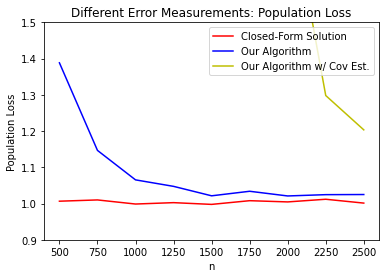

In [19]:
n_values = range(500,2700,250)#[500,1000,1500,2000,4000]#,6000,8000,10000]
d = 5
iters = 50
total_privacy_budget=0.5

losses(n_values, d, iters, total_privacy_budget, pop_loss)